In [1]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util import util
from tensorflow import keras

figsize = (20, 4.5)

# Loading data
data = util.load_data(data_folder='data', fnames=['train_FD004'])
dt_in = list(data.columns[3:-1])

# Split training and test set
tr, ts = util.split_train_test_machines(data, tr_ratio=0.75, seed=42)
tr_mcn = tr["machine"].unique()
ts_mcn = ts["machine"].unique()
# Rescale
tr_s, ts_s, nparams = util.rescale_CMAPSS(tr, ts)
# Configure the cost model
tr_failtimes = tr.groupby('machine')['cycle'].max()
safe_interval = tr_failtimes.min()
maintenance_cost = tr_failtimes.max()
cmodel = util.RULCostModel(maintenance_cost, safe_interval)

# RUL-Based Policy as Classification

## An Alternative Formulation

**Let's consider an alternative formulation for our policy**

* Rather than building a RUL estimator
* ...And triggering maintenance when the estimate is too low

...We could train _a single model_ to do all the work instead

**Such a model may work as follows**

* If the RUL is larger than $\theta$, the output is 1 (all fine)
* Otherwise, the output is 0 (we need to stop)

Rather than a numerical quantity, we have a _discrete_ one

**We say that our model is a _classifier_**

* A typical classifier would be an image recognizer
* ...But this one fits the definition, too

## NN Classifier

**As we have seen, we can easily define a NN classifier**

...By using a sigmoid activation function on the output layer

<center><img src="assets/sigmoid.png" width="400px"/></center>

**With this change, we can view the NN output as a _probability_**

Specifically, as the probability that the class is 1

* If this is $> 0.5$, we say the class is 1
* If it is $< 0.5$, then the class is 0

## NN Classifier

**As we have seen, we can easily define a NN classifier**

...By using a sigmoid activation function on the output layer

<center><img src="assets/sigmoid.png" width="400px"/></center>

**Our ground truth changes**

* Rather than targets (i.e. numerical quantities to estimate)
* We have categorical values (a.k.a. _labels_)

## Labels vs Targets

**Our ground truth changes**

* Rather than targets (i.e. numerical quantities to estimate)
* We have categorical values (a.k.a. _labels_)

We obtain them by just comparing the RUL with our chosen $\theta$

In [3]:
class_thr = 18
tr_lbl = (tr['rul'] >= class_thr)
ts_lbl = (ts['rul'] >= class_thr)

The resulting vector contain the outcome of the comparison

* I.e. `tr_lbl` contains `True` if the RUL was larger than $\theta$
* ...And `False` otherwise

## A Logistic Regression Model

**We will start by building the simpler possible NN classifier**

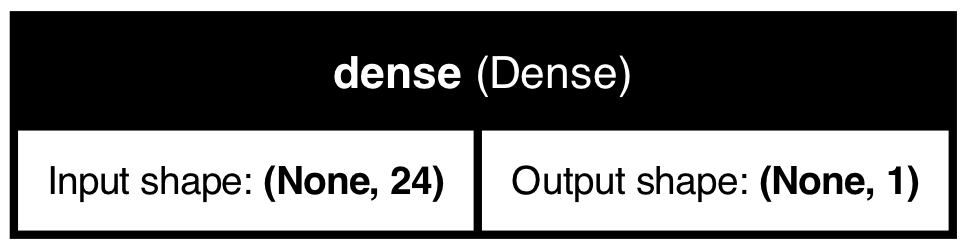

In [4]:
hidden = []
nn = util.build_ml_model(input_size=(len(dt_in),), output_size=1, hidden=hidden, output_activation='sigmoid')
util.plot_ml_model(nn)

* It's the same as our Liner Regressor
* ...Except that we have a sigmoid activation on the output function

This is called a _Logistic Regressor_

## A Logistic Regression Model

**Next, we trigger the training process**

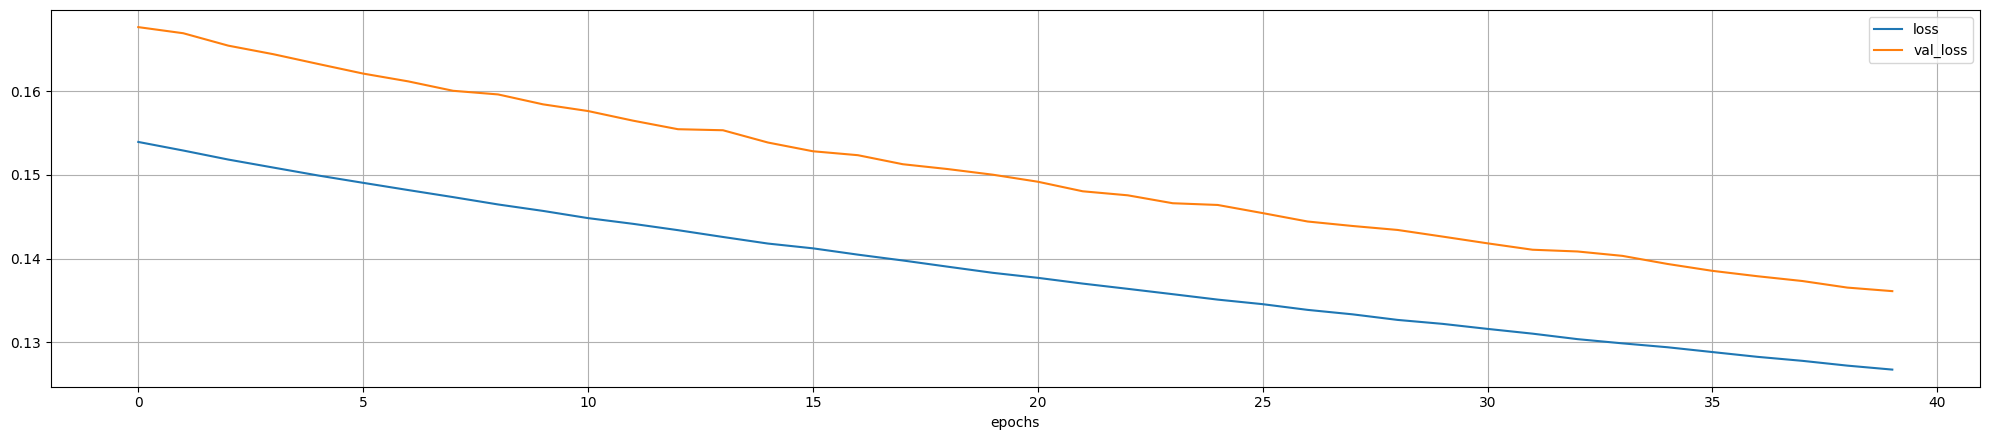

Final loss: 0.1267 (training), 0.1361 (validation)


In [6]:
history = util.train_ml_model(nn, tr_s[dt_in], tr_lbl, epochs=40, validation_split=0.2, loss='binary_crossentropy')
util.plot_training_history(history, figsize=figsize)

## An MLP Classifier Model

**Now, let's try with a deeper model**

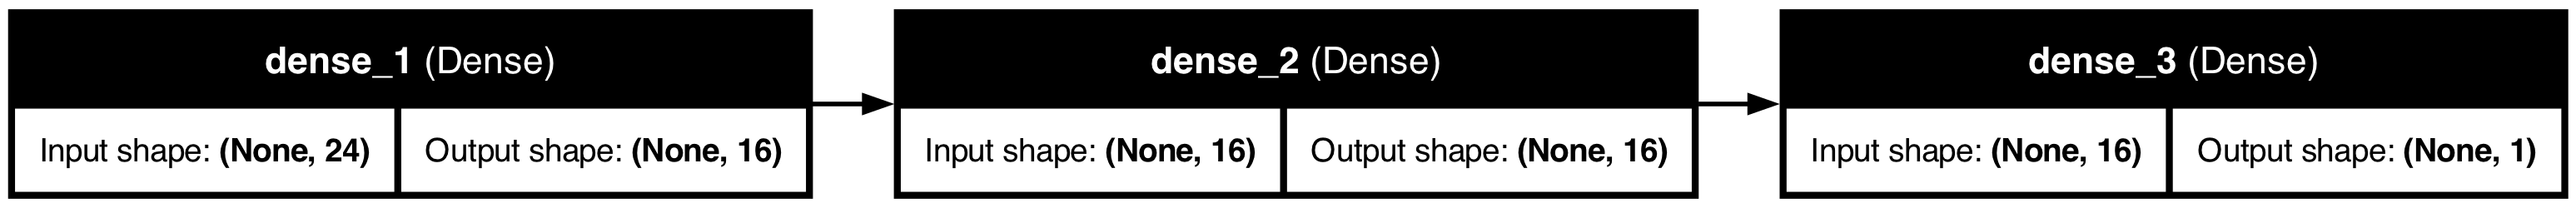

In [7]:
hidden = [16, 16]
nn2 = util.build_ml_model(input_size=(len(dt_in),), output_size=1, hidden=hidden, output_activation='sigmoid')
util.plot_ml_model(nn2)

Once again, we have introduced two hidden layers

* We can view each layer as a function which _transforms_ its input
* The last layer then is a Logistic Regressor on the transformed data

## An MLP Classifier Model

**Let's perform training and check the results**

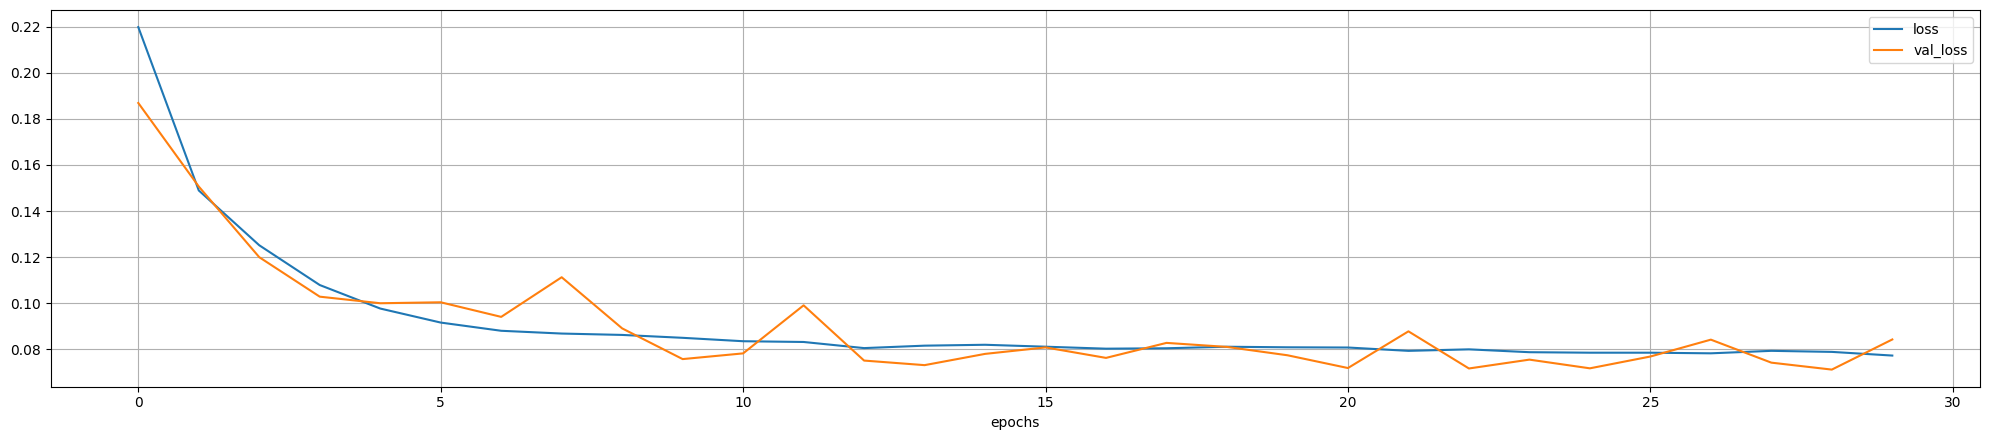

Final loss: 0.0773 (training), 0.0843 (validation)


In [8]:
history = util.train_ml_model(nn2, tr_s[dt_in], tr_lbl, epochs=30, validation_split=0.2, loss='binary_crossentropy')
util.plot_training_history(history, figsize=figsize)

A deeper network in this case works much better

## Inspecting the Predictions

**Let's check our raw predictions (probabilities) over time**

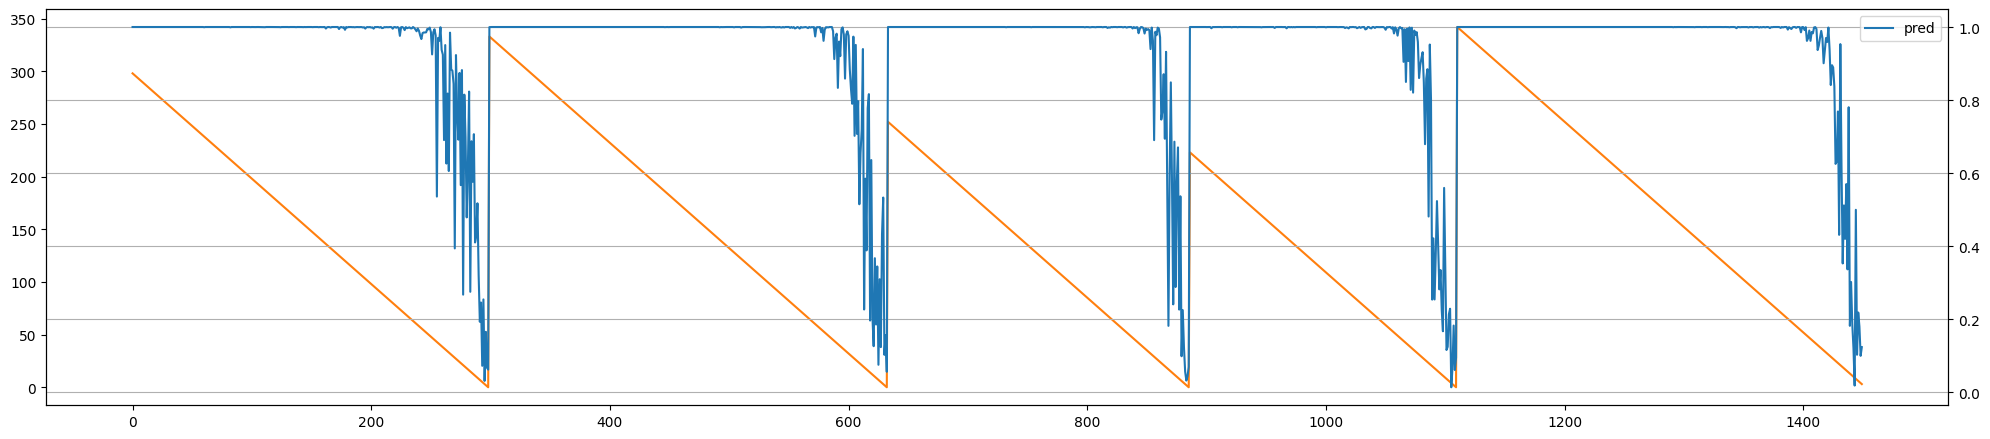

In [9]:
ts_prob2 = nn2.predict(ts_s[dt_in], verbose=0).ravel()
stop = 1450
util.plot_rul(ts_prob2[:stop], ts['rul'][:stop], same_scale=False, figsize=figsize)

## Inspecting the Predictions

**After rounding is applied, this is what we get**

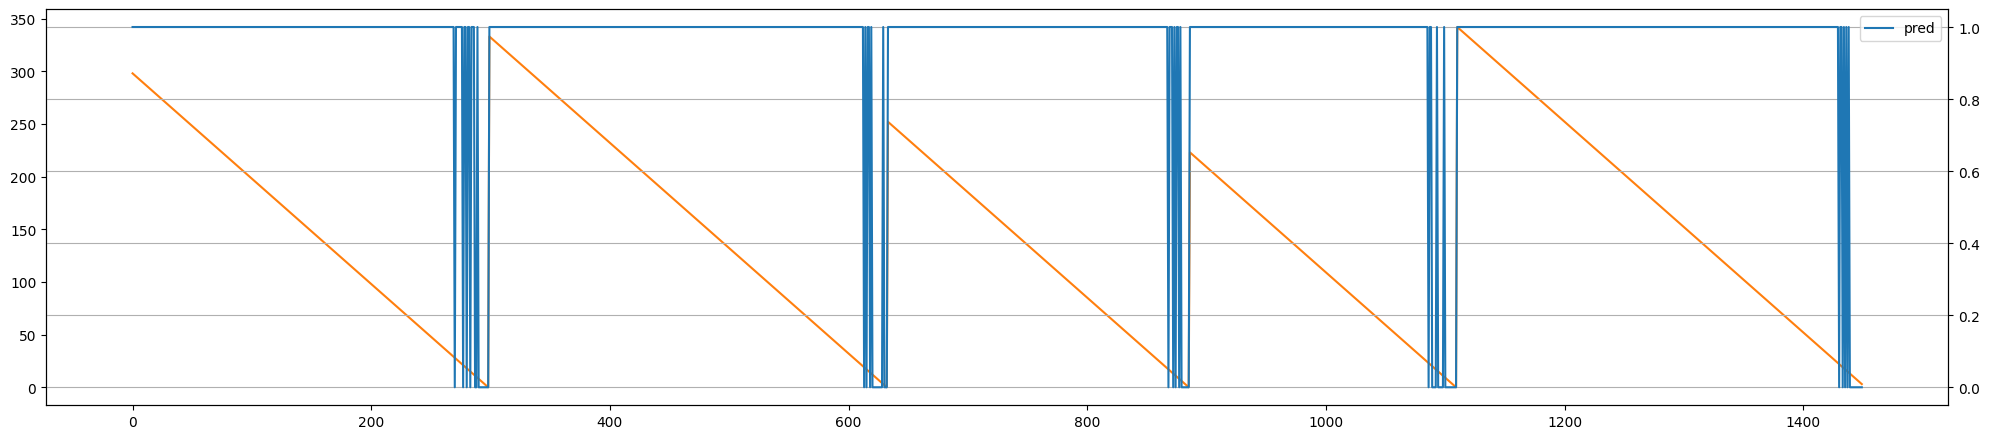

In [10]:
ts_pred2 = np.round(nn2.predict(ts_s[dt_in], verbose=0).ravel())
util.plot_rul(ts_pred2[:stop], ts['rul'][:stop], same_scale=False, figsize=figsize)

## Evaluating the Policy

**We can evaluate the classifier _directly_**

...Because it defines the whole policy, with no need for additional calibration

In [11]:
tr_pred2 = np.round(nn2.predict(tr_s[dt_in], verbose=0).ravel())
ts_pred2 = np.round(nn2.predict(ts_s[dt_in], verbose=0).ravel())

tr_c2, tr_f2, tr_s2 = cmodel.cost(tr['machine'].values, tr_pred2, 0.5, return_margin=True)
ts_c2, ts_f2, ts_s2 = cmodel.cost(ts['machine'].values, ts_pred2, 0.5, return_margin=True)

print(f'Cost: {tr_c2/len(tr_mcn):.2f} (training), {ts_c2/len(ts_mcn):.2f} (test)')
print(f'Avg. fails: {tr_f2/len(tr_mcn)} (training), {ts_f2/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_s2/len(tr_mcn):.2f} (training), {ts_s2/len(ts_mcn):.2f} (test)')

Cost: -90.65 (training), -100.38 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 25.67 (training), 23.65 (test)


Which is comparable with our earlier results